In [1]:
from matplotlib import pyplot
import numpy
from scipy.linalg import solve_triangular

### General Form of a Gaussian

$p(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu - \ln Z)$

with $\ln Z = \frac{1}{2}\nu^\top\Lambda^{-1}\nu + \frac{D}{2}\ln 2\pi + \frac{1}{2}\ln\det(\Lambda^{-1})$.

### Relation to covariance and mean

$\Sigma = \Lambda^{-1}$

$\mu = \Sigma\nu$

### Form of unnormalised Gaussians

$u(x) = \exp(-\frac{1}{2}x^\top\Lambda x + x^\top\nu + \ln \beta)$

And the intergal is

$\int u(x) d x = \beta Z$

### List of intergals

In [18]:
class SquaredExponential:
    
    def __init__(self, Lambda: numpy.ndarray, nu: numpy.ndarray=None, ln_beta: numpy.ndarray=None):
        """ A general term, which can be added to a Gaussian.
        
        u(x) = beta * exp(- 0.5 * x'Lambda x + x'nu),
    
        D is the dimension, and R the number of Gaussians.

        :param Lambda: numpy.ndarray [R, D, D]
            Information (precision) matrix of the Gaussian distributions.
        :param nu: numpy.ndarray [R, D]
            Information vector of a Gaussian distribution. If None all zeros. (Default=None)
        :param ln_beta: numpy.ndarray [R]
            The log constant factor of the squared exponential. If None all zeros. (Default=None)
        """
        
        self.Lambda = Lambda
        self.R, self.D = self.Lambda.shape[0], self.Lambda.shape[1]
        if nu is None:
            self.nu = numpy.zeros((self.R, self.D))
        else:
            self.nu = nu
        if ln_beta is None:
            self.ln_beta = numpy.zeros((self.R))
        else:
            self.ln_beta = ln_beta
        self.Sigma = None
        self.ln_det_Lambda = None
        self.ln_det_Sigma = None
        self.lnZ = None
        self.mu = None
        
        
    def compute_lnZ(self):
        """ Computes the log partition function.
        """
        if self.ln_det_Sigma is None:
            self.invert_lambda()
        nu_Lambda_nu = numpy.einsum('rd,rd->r', numpy.einsum('rdd,rd->rd', self.Sigma, self.nu), self.nu)
        self.lnZ = .5 * (nu_Lambda_nu + self.D * numpy.log(2. * numpy.pi) + self.ln_det_Sigma)
            
        
    def evaluate_ln(self, x: numpy.ndarray, r: list=[]):
        """ Evaluates the log-exponential term at x.
        
        :param x: numpy.ndarray [N, D]
            Points where the squared exponential should be evaluated.
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: numpy.ndarray [N, R] or [N, len(r)]
            Log exponential term.
        """
        if len(r) == 0:
            r = range(self.R)
        x_Lambda_x = numpy.einsum('adc,dc->ad', numpy.einsum('abc,dc->adb', self.Lambda[r], x), x)
        x_nu = numpy.dot(x, self.nu[r].T).T
        return - .5 * x_Lambda_x + x_nu + self.ln_beta[r,None]
    
    def evaluate(self, x: numpy.ndarray, r: list=[]):
        """ Evaluates the exponential term at x.
        
        :param x: numpy.ndarray [N, D]
            Points where the squared exponential should be evaluated.
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: numpy.ndarray [N, R] or [N, len(r)]
            Exponential term.
        """
        return numpy.exp(self.evaluate_ln(x, r))
    
    def invert_lambda(self):
        self.Sigma, self.ln_det_Lambda = self.invert_matrix(self.Lambda)
        self.ln_det_Sigma = -self.ln_det_Lambda
                    
    @staticmethod
    def invert_matrix(A):
        L = numpy.linalg.cholesky(A)
        # TODO: Check whether we can make it mor efficienty with solve_triangular.
        #L_inv = solve_triangular(L, numpy.eye(L.shape[0]), lower=True,
        #                         check_finite=False)
        L_inv = numpy.linalg.solve(L, numpy.eye(L.shape[1])[None])
        A_inv = numpy.einsum('acb,acd->abd', L_inv, L_inv)
        ln_det_A = 2. * numpy.sum(numpy.log(L.diagonal(axis1=1, axis2=2)), axis=1)
        return A_inv, ln_det_A
    
    @staticmethod
    def get_trace(A):
        return numpy.sum(A.diagonal(axis1=1,axis2=2), axis=1)
    
    def multiply_squared_exponential(self, factor: 'SquaredExponential', r: list=[]):
        """ Multiplies an exponential factor with another one.
        
        u_1(x) * u_2(x)
        
        :param factor: SquaredExponential
            Factor the object is multiplied with. The number of Gaussians in the resulting object are R * factor.R
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
        
        :return: SquaredExponential
            The resulting object.
        """
        if len(r) == 0:
            r = range(self.R)
        R = len(r)
        Lambda = (self.Lambda[r,None] + factor.Lambda[None]).reshape((R * factor.R, self.D, self.D))
        nu = (self.nu[r,None] + factor.nu[None]).reshape((R * factor.R, self.D))
        ln_beta = (self.ln_beta[r,None] + factor.ln_beta[None]).reshape((R * factor.R))
        product = SquaredExponential(Lambda=Lambda, nu=nu, ln_beta=ln_beta)
        return product
    
    def multiply_rank_one(self, U: numpy.ndarray, G: numpy.ndarray, nu: numpy.ndarray=None, ln_beta: numpy.ndarray=None, r: list=[]):
        """ Multiplies the exponential term with another exponential term, where the Lambda is rank 1, i.e.
        
        Lambda = U G U'
            
        Where G is an [1 x 1] diagonal matrix and U and [D x 1] with a vector. If already computed, the covariance matrix Sigma and its log-determinant are efficiently updated.
        
        :param U: numpy.ndarray [R1, D]
            Vector of low rank matrix with orthogonal vectors.
        :param G: numpy.ndarray [R1]
            Diagonal entries of the low-rank matrix.
        :param nu: numpy.ndarray [R1, D]
            Information vector of the low rank part. If None all entries are zero. (Default=None)
        :param nu: numpy.ndarray [R1]
            Log factor of the low rank part. If None all entries are zero. (Default=None)
        :param r: list
            Indices of densities that need to be evaluated. If empty, all densities are evaluated. (Default=[])
            
        :return: Squared exponential
            The resulting product, where the number of Gaussians is self.R * R1.
        """
        if len(r) == 0:
            r = range(self.R)
        R = len(r)
        R1 = G.shape[0]
        UGU = numpy.einsum('rd,rs->rds', U, G[:,None] * U)
        Lambda_new = (self.Lambda[r,None] + UGU[None]).reshape((R * R1, self.D, self.D))
        if nu is None:
            nu_new = numpy.tile(self.nu, (R1, 1))
        else:
            nu_new = (self.nu[r,None] + nu[None]).reshape((R * R1, self.D))
        if ln_beta is None:
            ln_beta_new = numpy.tile(self.ln_beta, (R1))
        else:
            ln_beta_new = (self.ln_beta[r,None] + ln_beta[None]).reshape((R * R1))
        product = SquaredExponential(Lambda=Lambda_new, nu=nu_new, ln_beta=ln_beta_new)
        
        # if the Sigma of the object is known the Sherman-morrison formula and the matrix determinant lemma are used for efficient update of the inverses and the log determinants.
        if self.Sigma is not None and self.ln_det_Sigma is not None:
            # Sherman morrison inversion
            G_inv = 1. / G
            Sigma_U = numpy.einsum('rsdd,rsd->rsd', self.Sigma[r,None], U[None])
            U_Sigma_U = numpy.einsum('rsd,rsd->rs', Sigma_U, U[None])
            denominator = 1. + G[None] * U_Sigma_U
            nominator = G[None] * numpy.einsum('rsd,rsk->rsdk', Sigma_U, Sigma_U)
            Sigma_new = self.Sigma[r, None] - nominator / denominator[:,:,None,None]
            product.Sigma = Sigma_new.reshape((R*R1, self.D, self.D))
            # Matrix determinant lemma
            ln_det_Sigma_new = self.ln_det_Sigma[r,None] - numpy.log(denominator)
            product.ln_det_Sigma = ln_det_Sigma_new.reshape((R * R1))
            product.ln_det_Lambda = -product.ln_det_Sigma
        return product
    
    def log_integral(self):
        """ Computes the log integral of the exponential term.
        
        log \int u(x) dx.
        
        :return: numpy.ndarray [R]
            Log integral
        """
        self._prepare_inegration()
        return self.lnZ + self.ln_beta
    
    def integral(self):
        """ Computes the log integral of the exponential term.
        
        \int u(x) dx.
        
        :return: numpy.ndarray [R]
            Integral
        """
        return numpy.exp(self.log_integral())
    
    def normalize(self):
        """ Normalizes the term such that
        
        int u(x) dx = 1.
        """
        self.ln_beta = -self.log_integral()
        
    def is_normalized(self):
        return numpy.equal(self.lnZ, -self.ln_beta)
    
    def compute_mu(self):
        """ Converts from information to mean vector.
        
        :return: numpy.ndarray [R, D]
            Mean vector.
        """
        if self.Sigma is None:
            self.invert_lambda()
        self.mu = numpy.einsum('abc,ac->ab', self.Sigma, self.nu)
    
    def get_density(self):
        """ Returns the corresponing normalised density object.
        
        :return: GaussianDensity
            Corresponding density object.
        """
        self._prepare_inegration()
        return GaussianDensity(Sigma=self.Sigma, mu=mu, Lambda=self.Lambda, ln_det_Sigma=self.ln_det_Sigma)
    
    def _prepare_inegration(self):
        if self.lnZ is None:
            self.compute_lnZ()
        if self.mu is None:
            self.compute_mu()
            
    ##### Linear intergals
            
    def _expectation_x(self):
        """ Computes the expectation.
        
            int x du(x) / int du(x)
        
        :return: numpy.ndarray [R, D]
            The solved intergal.
        """
        return self.mu 
            
    def intergrate_x(self):
        """ Computes the integral.
        
            int x du(x)
        
        :return: numpy.ndarray [R, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None] * self._expectation_x()
    
    ##### Quadratic integrals
    
    def _expectation_xxT(self):
        """ Computes the expectation.
        
            int xx' du(x) / int du(x)
        
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        return self.Sigma + numpy.einsum('ab,ac->acb', self.mu, self.mu)
    
    def intergrate_xxT(self):
        """ Computes the integral.
        
            int xx' du(x)
        
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xxT()
    
    ##### Cubic integrals
    
    def _expectation_xbxx(self, b_vec: numpy.ndarray):
        """ Computes the cubic expectation.
        
            int xb'xx' dphi(x),
            
            with phi(x) = u(x) / int du(x).
            
        :param b_vec: numpy.ndarray [D,]
            Vector of 
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        Exx = self._expectation_xxT()
        mub_outer = numpy.einsum('ab,c->abc', self.mu, b_vec)
        mbExx = numpy.einsum('abc,acd->abd', mub_outer, Exx)
        bmu_inner = numpy.einsum('ab,b->a', self.mu, b_vec)
        bmSigma = numpy.einsum('a,abc->abc', bmu_inner, self.Sigma)
        bmu_outer = numpy.einsum('a,bc->bac', b_vec, self.mu)
        Sigmabm = numpy.einsum('abd,ade->abe', self.Sigma, bmu_outer)
        return mbExx + bmSigma + Sigmabm
        
    
    def intergate_xbxx(self, b_vec: numpy.ndarray):
        """ Computes the cubic integral.
        
            int xb'xx' du(x)
        :param b_vec: numpy.ndarray [D,]
            Vector of 
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xbxx(b_vec)
    
    
    ##### Quartic integrals
    
    def _expectation_xxTxxT(self):
        """ Computes the cubic integral.
        
            int xx'xx' dphi(x),
            
            with phi(x) = u(x) / int du(x).
            
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        mumu_outer = numpy.einsum('ab,ac->acb', self.mu, self.mu)
        Sigma_mumu_p = self.Sigma + mumu_outer
        Sigma_mumu_m = self.Sigma - mumu_outer
        mumu_inner = numpy.einsum('ab,ab->a', self.mu, self.mu)
        Sigma_trace = self.get_trace(self.Sigma)
        Sigma_mumu_p2 = numpy.einsum('abc,acd->abd', Sigma_mumu_p, Sigma_mumu_p)
        return 2. * Sigma_mumu_p2 + mumu_inner[:,None,None] * Sigma_mumu_m + Sigma_trace[:,None,None] * Sigma_mumu_p
        
    def integrate_xxTxxT(self):
        """ Computes the quartic integral.
        
            int xx'xx' du(x).
            
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xxTxxT()
    
    def _expectation_xxTAxxT(self, A_mat: numpy.ndarray):
        """ Computes the quartic expectation.
        
            int xx'Axx' dphi(x),
            
            with phi(x) = u(x) / int du(x).
            
        :param A: numpy.ndarray [D,D]
            Square matrix.
            
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        mumu_outer = numpy.einsum('ab,ac->acb', self.mu, self.mu)
        Sigma_mumu_p = self.Sigma + mumu_outer
        Sigma_mumu_m = self.Sigma - mumu_outer
        AAT = A_mat + A_mat.T
        Sigma_AA_Sigma = numpy.einsum('abc, acd->abd', numpy.einsum('abc,cd->abd', Sigma_mumu_p, AAT), Sigma_mumu_p)
        muAmu = numpy.einsum('ab,ab->a', self.mu, numpy.einsum('ab,ca-> cb', A_mat, self.mu))
        ASigma_trace = self.get_trace(numpy.einsum('ab,cbd->cad', A_mat, self.Sigma))
        return Sigma_AA_Sigma + muAmu[:,None,None] * Sigma_mumu_m + ASigma_trace[:,None,None] * Sigma_mumu_p
    
    def integrate_xxTAxxT(self, A_mat: numpy.ndarray):
        """ Computes the quartic integral.
        
            int xx'xx' du(x)
        :return: numpy.ndarray [R, D, D]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_xxTAxxT(A_mat)
    
    def _expectation_general_quartic_outer(self, A_mat: numpy.ndarray, a_vec: numpy.ndarray, B_mat: numpy.ndarray, b_vec: numpy.ndarray, 
                                           C_mat: numpy.ndarray, c_vec: numpy.ndarray, D_mat: numpy.ndarray, d_vec: numpy.ndarray):
        """ Computes the quartic expectation.
        
            int (Ax+a)(Bx+b)'(Cx+c)(Dx+d)' dphi(x),
            
            with phi(x) = u(x) / int du(x).
            
        :param A_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param a_vec: numpy.ndarray [K]
            Real valued vector.
        :param B_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param b_vec: numpy.ndarray [L]
            Real valued vector.
        :param C_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param c_vec: numpy.ndarray [L]
            Real valued vector.
        :param D_mat: numpy.ndarray [M,D]
            Real valued matrix.
        :param d_vec: numpy.ndarray [M]
            Real valued vector.
            
        :return: numpy.ndarray [R, K, M]
            The solved intergal.
        """
        Amu_a = numpy.einsum('ab,cb-> ca', A_mat, self.mu) + a_vec[None]
        Bmu_b = numpy.einsum('ab,cb-> ca', B_mat, self.mu) + b_vec[None]
        Cmu_c = numpy.einsum('ab,cb-> ca', C_mat, self.mu) + c_vec[None]
        Dmu_d = numpy.einsum('ab,cb-> ca', D_mat, self.mu) + d_vec[None]
        ASigmaB = numpy.einsum('ab,cbd->cad', A_mat, numpy.einsum('abc,cd->abd', self.Sigma, B_mat.T))
        CSigmaD = numpy.einsum('ab,cbd->cad', C_mat, numpy.einsum('abc,cd->abd', self.Sigma, D_mat.T))
        ASigmaC = numpy.einsum('ab,cbd->cad', A_mat, numpy.einsum('abc,cd->abd', self.Sigma, C_mat.T))
        BSigmaD = numpy.einsum('ab,cbd->cad', B_mat, numpy.einsum('abc,cd->abd', self.Sigma, D_mat.T))
        ASigmaD = numpy.einsum('ab,cbd->cad', A_mat, numpy.einsum('abc,cd->abd', self.Sigma, D_mat.T))
        BSigmaC = numpy.einsum('ab,cbd->cad', B_mat, numpy.einsum('abc,cd->abd', self.Sigma, C_mat.T))
        AmuaBmub = numpy.einsum('ab,ac->abc', Amu_a, Bmu_b)
        CmucDmud = numpy.einsum('ab,ac->abc', Cmu_c, Dmu_d)
        AmuaCmuc = numpy.einsum('ab,ac->abc', Amu_a, Cmu_c)
        BmubDmud = numpy.einsum('ab,ac->abc', Bmu_b, Dmu_d)
        BmubCmuc = numpy.einsum('ab,ab->a', Bmu_b, Cmu_c)
        AmuaDmud = numpy.einsum('ab,ac->abc', Amu_a, Dmu_d)
        first_term = numpy.einsum('abc,acd->abd', ASigmaB + AmuaBmub, CSigmaD + CmucDmud)
        second_term = numpy.einsum('abc,acd->abd', ASigmaC + AmuaCmuc, BSigmaD + BmubDmud)
        third_term = BmubCmuc[:,None,None] * (ASigmaD - AmuaDmud)
        fourth_term = self.get_trace(BSigmaC)[:,None,None] * (ASigmaD + AmuaDmud)
        return first_term + second_term + third_term + fourth_term
        
    def integral_general_quartic_outer(self, A_mat: numpy.ndarray, a_vec: numpy.ndarray, B_mat: numpy.ndarray, b_vec: numpy.ndarray, 
                                       C_mat: numpy.ndarray, c_vec: numpy.ndarray, D_mat: numpy.ndarray, d_vec: numpy.ndarray):
        """ Computes the quartic integral.
        
            int (Ax+a)(Bx+b)'(Cx+c)(Dx+d)' du(x).
            
        :param A_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param a_vec: numpy.ndarray [K]
            Real valued vector.
        :param B_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param b_vec: numpy.ndarray [L]
            Real valued vector.
        :param C_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param c_vec: numpy.ndarray [L]
            Real valued vector.
        :param D_mat: numpy.ndarray [M,D]
            Real valued matrix.
        :param d_vec: numpy.ndarray [M]
            Real valued vector.
            
        :return: numpy.ndarray [R, K, M]
            The solved intergal.
        """
        constant = self.integral()
        return constant[:,None,None] * self._expectation_general_quartic_outer(A_mat,a_vec,B_mat,b_vec,C_mat,c_vec,D_mat,d_vec)
    
    def _expectation_general_quartic_inner(self, A_mat: numpy.ndarray, a_vec: numpy.ndarray, B_mat: numpy.ndarray, b_vec: numpy.ndarray, 
                                           C_mat: numpy.ndarray, c_vec: numpy.ndarray, D_mat: numpy.ndarray, d_vec: numpy.ndarray):
        """ Computes the quartic expectation.
        
            int (Ax+a)'(Bx+b)(Cx+c)'(Dx+d) dphi(x),
            
            with phi(x) = u(x) / int du(x).
            
        :param A_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param a_vec: numpy.ndarray [K]
            Real valued vector.
        :param B_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param b_vec: numpy.ndarray [L]
            Real valued vector.
        :param C_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param c_vec: numpy.ndarray [L]
            Real valued vector.
        :param D_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param d_vec: numpy.ndarray [L]
            Real valued vector.
            
        :return: numpy.ndarray [R]
            The solved intergal.
        """
        Amu_a = numpy.einsum('ab,cb-> ca', A_mat, self.mu) + a_vec[None]
        Bmu_b = numpy.einsum('ab,cb-> ca', B_mat, self.mu) + b_vec[None]
        Cmu_c = numpy.einsum('ab,cb-> ca', C_mat, self.mu) + c_vec[None]
        Dmu_d = numpy.einsum('ab,cb-> ca', D_mat, self.mu) + d_vec[None]
        ASigmaB = numpy.einsum('ab,cbd->cad', A_mat, numpy.einsum('abc,cd->abd', self.Sigma, B_mat.T))
        CSigmaD = numpy.einsum('ab,cbd->cad', C_mat, numpy.einsum('abc,cd->abd', self.Sigma, D_mat.T))
        
        AmuaBmub = numpy.einsum('ab,ab->a', Amu_a, Bmu_b)
        CmucDmud = numpy.einsum('ab,ab->a', Cmu_c, Dmu_d)
        CD = numpy.dot(C_mat.T, D_mat)
        CD_DC = CD + CD.T
        SCD_DCS = numpy.einsum('abc,acd->abd', numpy.einsum('abc,cd->abd', self.Sigma, CD_DC), self.Sigma)
        ASCD_DCSB = numpy.einsum('abc,dc->abd', numpy.einsum('ab,cbd->cad', A_mat, SCD_DCS), B_mat)
        Am_aB = numpy.einsum('ab,bc->ac', Amu_a, B_mat)
        Bm_bA = numpy.einsum('ab,bc->ac', Bmu_b, A_mat)
        CDm_d = numpy.einsum('ab,ca->cb', C_mat, Dmu_d)
        DCm_c = numpy.einsum('ab,ca->cb', D_mat, Cmu_c)
        first_term = self.get_trace(ASCD_DCSB)
        second_term = numpy.einsum('ab,ab->a', numpy.einsum('ab,abc->ac', Am_aB + Bm_bA, self.Sigma), CDm_d + DCm_c)
        third_term = (self.get_trace(ASigmaB) + AmuaBmub) * (self.get_trace(CSigmaD) + CmucDmud)
        return first_term + second_term + third_term
        
    def integral_general_quartic_inner(self, A: numpy.ndarray, a_vec: numpy.ndarray, B: numpy.ndarray, b_vec: numpy.ndarray, 
                                       C: numpy.ndarray, c_vec: numpy.ndarray, D: numpy.ndarray, d_vec: numpy.ndarray):
        """ Computes the quartic integral.
        
            int (Ax+a)(Bx+b)'(Cx+c)(Dx+d)' du(x).
            
        :param A_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param a_vec: numpy.ndarray [K]
            Real valued vector.
        :param B_mat: numpy.ndarray [K,D]
            Real valued matrix.
        :param b_vec: numpy.ndarray [K]
            Real valued vector.
        :param C_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param c_vec: numpy.ndarray [L]
            Real valued vector.
        :param D_mat: numpy.ndarray [L,D]
            Real valued matrix.
        :param d_vec: numpy.ndarray [L]
            Real valued vector.
            
        :return: numpy.ndarray [R]
            The solved intergal.
        """
        constant = self.integral()
        return constant * self._expectation_general_quartic_inner(A_mat,a_vec,B_mat,b_vec,C_mat,c_vec,D_mat,d_vec)

    
class DiagonalSquaredExponential(SquaredExponential):
    
    def invert_lambda(self):
        self.Sigma = numpy.diag(self.Lambda.diagonal())
        self.ln_det_Lambda = numpy.sum(numpy.log(self.Lambda.diagonal()))
        self.ln_det_Sigma = -self.ln_det_Lambda   
    
class GaussianDensity(SquaredExponential):
    
    def __init__(self, Sigma: numpy.ndarray, mu: numpy.ndarray, Lambda: numpy.ndarray=None, ln_det_Sigma: numpy.ndarray=None):
        """ A normalized Gaussian density, with specified mean and covariance matrix.
        
        :param Sigma: numpy.ndarray [R, D, D]
            Covariance matrices of the Gaussian densities.
        :param mu: numpy.ndarray [R, D]
            Mean of the Gaussians.
        :param Lambda: numpy.ndarray [R, D, D] or None
            Information (precision) matrix of the Gaussians. (Default=None)
        :param ln_det_Sigma: numpy.ndarray [R] or None
            Log determinant of the covariance matrix. (Default=None)
        """
        if Lambda is None:
            Lambda, ln_det_Sigma = self.invert_matrix(Sigma)
        elif ln_det_Sigma is None:
            ln_det_Sigma = numpy.linalg.slogdet(Sigma)[1]
        nu = numpy.einsum('abc,ab->ac', Lambda, mu)
        super().__init__(Lambda=Lambda, nu=nu)
        self.Sigma = Sigma
        self.ln_det_Sigma = ln_det_Sigma
        self.ln_det_Lambda = -ln_det_Sigma
        self.normalize()
        
    def sample(self, num_samples: int):
        L = numpy.linalg.cholesky(self.Sigma)
        rand_nums = numpy.random.randn(num_samples, self.R, self.D)
        x_samples = self.mu[None] + numpy.einsum('abc,dac->dab', L, rand_nums)
        return x_samples
                                       
class SphericalGaussianDensity(GaussianDensity):
    
    def __init__(self, Sigma: numpy.ndarray, mu: numpy.ndarray, Lambda: numpy.ndarray=None, ln_det_Sigma: numpy.ndarray=None):
        """ A normalized Gaussian density, with specified mean and covariance matrix.
        
        :param Sigma: numpy.ndarray [R, D, D]
            Covariance matrices of the Gaussian densities.
        :param mu: numpy.ndarray [R, D]
            Mean of the Gaussians.
        :param Lambda: numpy.ndarray [R, D, D] or None
            Information (precision) matrix of the Gaussians. (Default=None)
        :param ln_det_Sigma: numpy.ndarray [R] or None
            Log determinant of the covariance matrix. (Default=None)
        """
        if Lambda is None:
            Lambda = numpy.diag(Sigma.diagonal())
            ln_det_Sigma = numpy.sum(numpy.log(Sigma.diagonal()))
        elif ln_det_Sigma is None:
            ln_det_Sigma = numpy.sum(numpy.log(Sigma.diagonal()))
        nu = numpy.einsum('abc,ac->ab', Lambda, mu)
        super().__init__(Lambda=Lambda, nu=nu)
        self.Sigma = Sigma
        self.ln_det_Sigma = ln_det_Sigma
        self.ln_det_Lambda = -ln_det_Sigma
        self.mu = mu
        self.normalize()

### Test for 1 D

In [19]:
R, D, R1 = 2, 1, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * (rand_nums + rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

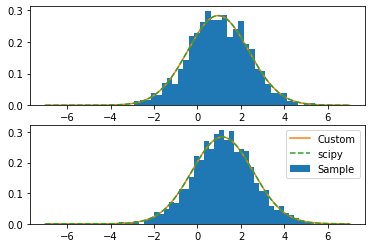

In [20]:
from scipy.stats import norm

xrange = numpy.linspace(-7,7,1000)
for ir in range(R):
    pyplot.subplot(R, 1, ir+1)
    scipy_gauss = norm.pdf(xrange, loc=mu_phi[ir], scale=numpy.sqrt(Sigma_phi[ir,0,0]))
    pyplot.hist(phi.sample(2000)[:,ir], bins=40, density=True, label='Sample')
    pyplot.plot(xrange, phi.evaluate(numpy.array([xrange]).T)[ir], label='Custom')
    pyplot.plot(xrange, scipy_gauss, '--', label='scipy')
pyplot.legend()
pyplot.show()

### Test for integral x

In [21]:
R, D, R1 = 10, 1, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

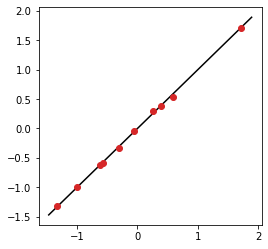

In [22]:
x_sample = numpy.mean(phi.sample(2000), axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)], [1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)] ,'k')
pyplot.plot(x_sample, phi.intergrate_x()[:,0], 'C3o')

In [23]:
R, D, R1 = 10, 3, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5 * numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

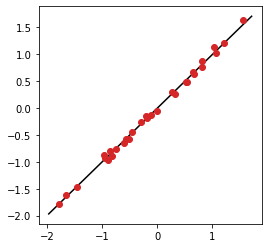

In [24]:
x_sample = numpy.mean(phi.sample(2000), axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)], [1.1 * numpy.amin(x_sample), 1.1 * numpy.amax(x_sample)] ,'k')
pyplot.plot(x_sample.flatten(), phi.intergrate_x().flatten(), 'C3o')

### Test for intergal xx

In [25]:
R, D, R1 = 10, 2, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D)
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

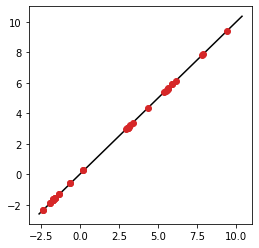

In [26]:
x_sample = phi.sample(100000)
x2_sample = numpy.mean(x_sample[:,:,None] * x_sample[:,:,:,None], axis=0)
pyplot.figure(figsize=(4,4))
pyplot.plot([1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)], [1.1 * numpy.amin(x2_sample), 1.1 * numpy.amax(x2_sample)] ,'k')
pyplot.plot(x2_sample.flatten(), phi.intergrate_xxT().flatten(), 'C3o')

### Test for cubic intergal

$\int xb^\top xx^\top du(x)$

In [27]:
R, D, R1 = 10, 5, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .5*(numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D))
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi =numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
b = numpy.random.randn(D)

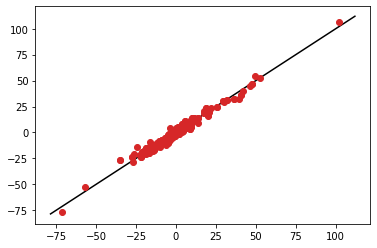

In [28]:
x_sample = phi.sample(1000)
Sigma_mumu_samples = x_sample[:,:,:,None] * x_sample[:,:,None]
xbxx_sample = numpy.mean(x_sample[:,:,:,None] * numpy.sum(b[None,None,:,None] * Sigma_mumu_samples, axis=2)[:,:,None], axis=0)
xbxx_phi = phi.intergate_xbxx(b)
pyplot.plot([1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)], [1.1 * numpy.amin(xbxx_sample), 1.1 * numpy.amax(xbxx_sample)] ,'k')
pyplot.plot(xbxx_sample.flatten(), xbxx_phi.flatten(), 'C3o')

## Test quartic integrals

$\int xx^\top xx^\top du(x)$ 

In [29]:
R, D, R1 = 100, 5, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .1*(numpy.dot(rand_nums, rand_nums.T) + D * numpy.eye(D))
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.random.randn(R, D)
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)

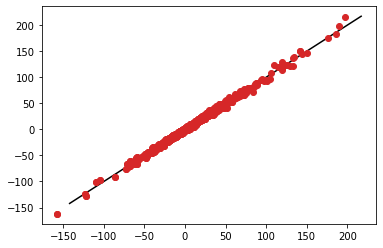

In [30]:
x_sample = phi.sample(1000)
Sigma_mumu_samples = x_sample[:,:,None] * x_sample[:,:,:,None]
xxxx_sample = numpy.mean(numpy.einsum('abcd,abde->abce', Sigma_mumu_samples, Sigma_mumu_samples), axis=0)
xxxx_phi = phi.integrate_xxTxxT()
pyplot.plot([.9 * numpy.amin(xxxx_sample), 1.1 * numpy.amax(xxxx_sample)], [.9 * numpy.amin(xxxx_sample), 1.1 * numpy.amax(xxxx_sample)] ,'k')
pyplot.plot(xxxx_sample.flatten(), xxxx_phi.flatten(), 'C3o')

$\int xx^\top A xx^\top du(x)$ 

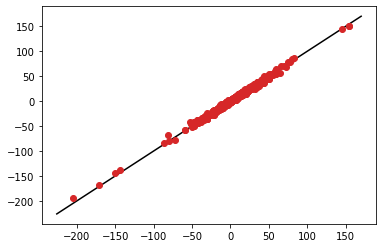

In [15]:
A = numpy.random.randn(D,D)
x_sample = phi.sample(1000)
Sigma_mumu_samples = x_sample[:,:,None] * x_sample[:,:,:,None]
xxA = numpy.einsum('abcd,de->abce', Sigma_mumu_samples, A)
xxAxx_sample = numpy.mean(numpy.einsum('abcd,abde->abce', xxA, Sigma_mumu_samples), axis=0)
xxAxx_phi = phi.integrate_xxTAxxT(A)
pyplot.plot([1.1 * numpy.amin(xxAxx_sample), 1.1 * numpy.amax(xxAxx_sample)], [1.1 * numpy.amin(xxAxx_sample), 1.1 * numpy.amax(xxAxx_sample)] ,'k')
pyplot.plot(xxAxx_sample.flatten(), xxAxx_phi.flatten(), 'C3o')

$\int (Ax+a)(Bx+b)^\top(Cx+c)(Dx+d)^\top du(x)$ 

In [16]:
m,l,k = 4,6,8
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(l,D), numpy.random.rand(l)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(k,D), numpy.random.rand(k)

x_sample = phi.sample(1000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abd->abcd', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abd->abcd', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(numpy.einsum('abcd,abde->abce', AB_sample, CD_sample), axis=0)
ABCD_phi = phi.integral_general_quartic_outer(A_mat, a_vec, B_mat, b_vec, C_mat, c_vec, D_mat, d_vec)

NameError: name 'd' is not defined

NameError: name 'ABCD_phi' is not defined

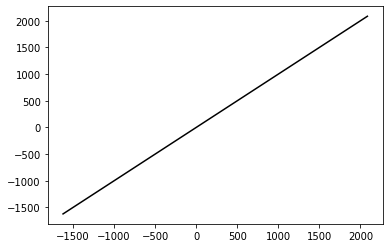

In [17]:
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

$\int (Ax+a)^\top(Bx+b)(Cx+c)^\top(Dx+d) du(x)$ 

In [42]:
m,l = 10,12
A_mat, a_vec = numpy.random.randn(m,D), numpy.random.rand(m)
B_mat, b_vec = numpy.random.randn(m,D), numpy.random.rand(m)
C_mat, c_vec = numpy.random.randn(l,D), numpy.random.rand(l)
D_mat, d_vec = numpy.random.randn(l,D), numpy.random.rand(l)

x_sample = phi.sample(1000)
Ax_a_sample = numpy.einsum('ab,cdb->cda', A_mat, x_sample) + a_vec
Bx_b_sample = numpy.einsum('ab,cdb->cda', B_mat, x_sample) + b_vec
Cx_c_sample = numpy.einsum('ab,cdb->cda', C_mat, x_sample) + c_vec
Dx_d_sample = numpy.einsum('ab,cdb->cda', D_mat, x_sample) + d_vec
AB_sample = numpy.einsum('abc,abc->ab', Ax_a_sample, Bx_b_sample)
CD_sample = numpy.einsum('abc,abc->ab', Cx_c_sample, Dx_d_sample)
ABCD_sample = numpy.mean(AB_sample * CD_sample, axis=0)
ABCD_phi = phi.integral_general_quartic_inner(A_mat, a_vec, B_mat, b_vec, C_mat, c_vec, D_mat, d_vec)

(100,) (100,) (100,)


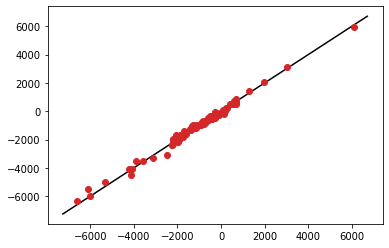

In [43]:
pyplot.plot([1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)], [1.1 * numpy.amin(ABCD_sample), 1.1 * numpy.amax(ABCD_sample)] ,'k')
pyplot.plot(ABCD_sample.flatten(), ABCD_phi.flatten(), 'C3o')

## Test 2 Dimensional

In [118]:
R, D, R1 = 1, 2, 1
rand_nums = numpy.random.randn(D,D)
Sigma_phi = .8 * numpy.eye(D) - .2
Sigma_phi = numpy.tile(Sigma_phi, (R, 1, 1))
mu_phi = numpy.zeros((R, D))
mu_phi[0,0] = 2 
phi = GaussianDensity(Sigma=Sigma_phi, mu=mu_phi)
x_samples = phi.sample(100000)
numpy_samples = numpy.random.multivariate_normal(mu_phi[0], Sigma_phi[0], 100000)

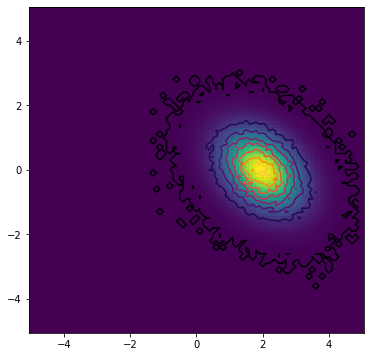

In [119]:
pyplot.figure(figsize=(6,6))
xrange = numpy.linspace(-5,5,100)
xmesh, ymesh = numpy.meshgrid(xrange, xrange)
x_grid = numpy.vstack([xmesh.flatten(), ymesh.flatten()])
density = phi.evaluate(x_grid.T)[0].reshape((100,100))
hist, xedges, yedges =  numpy.histogram2d(x_samples[:,0,1], x_samples[:,0,0], range=[[-5,5], [-5,5]], bins=100)
numpy_hist, xedges, yedges =  numpy.histogram2d(numpy_samples[:,1], numpy_samples[:,0], range=[[-5,5], [-5,5]], bins=100)
ax1 = pyplot.subplot(111)
pyplot.pcolor(xrange, xrange, density, shading='auto')
#pyplot.pcolor(xedges[:-1], yedges[:-1], numpy_hist, shading='auto')
pyplot.contour(xedges[:-1], yedges[:-1], hist, cmap='inferno')
pyplot.show()